In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
from torch.distributions.bernoulli import Bernoulli

In [ ]:
!python --version

Python 3.8.15


In [ ]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        #self.sigma = log_sigma.exp()
        self.sigma = torch.exp(log_sigma)
        #self.sigma = torch.exp(log_sigma - torch.max(log_sigma)) / torch.sum(torch.exp(log_sigma - torch.max(log_sigma)))
        #self.sigma = log_sigma

        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.sample_epsilon()*self.sigma + self.mu
        #raise NotImplementedError # <- your code
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -1/2*torch.log(self.sigma**2*2*math.pi)-1/2*((z-self.mu)/self.sigma)**2 #log of a gaussian distribution - reduced
        #raise NotImplementedError # <- your code

## READ DATA

In [ ]:
pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 4.9 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=236295 sha256=0f1d89a5dcae773a0a7af0d97becc3aad45684e3030182f74c96b61b5cbb74a3
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [ ]:
#Mount drive
import os.path
from os import path

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle5 as pickle

import pandas as pd
print(pd.__version__)

path = "/content/drive/My Drive/ColabNotebooks/projekt03/data_10000_images_v_135.pkl" #Directory Frederikke
#path = "/content/drive/My Drive/projekt03/data_10000_images_v_135.pkl" # Directory Jonathan
#path = "/content/drive/My Drive/ColabNotebooks/projekt03/data_10000_images_v_135.pkl" # Directory Johanne

with open(path, "rb") as fh:
  subset = pickle.load(fh)

1.3.5


In [ ]:
#convet labels into int
labels_names = subset.moa.unique()
label_to_label_id = {}
for i in range(len(labels_names)):
    label_to_label_id[labels_names[i]] = i

subset["labels_ID"] = subset.apply(lambda row: label_to_label_id[row.moa], axis=1)
subset["labels_ID"].dtypes

dtype('int64')

In [ ]:
#make new dataframe that dataloader can read
data = subset[['Images','labels_ID']].copy()
print(data.shape)

(10010, 2)


In [ ]:
#make dataset class
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class BBBC(Dataset):
    def __init__(self, annotations_file,typeFlag, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        train_size = int(np.ceil(0.6*annotations_file.shape[0]))
        test_size = int(np.ceil(0.2*annotations_file.shape[0]))

        img_labels = annotations_file

        if typeFlag == 'train':
          img_labels = annotations_file.iloc[0:train_size]
        elif typeFlag == 'test':
          img_labels = annotations_file.tail(test_size)
        elif typeFlag == 'validation':
          img_labels = annotations_file.iloc[train_size:train_size+test_size]
        
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_labels.iloc[idx, 0]
        
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        image = image.view(-1).type(torch.FloatTensor)
        image = (image-image.min())/(image.max()-image.min())
        image = image.view(3,68,68).type(torch.FloatTensor)

        return image, int(label)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        flattend = input.view(input.size(0), -1)
        #dim = flattend[1].size()[0]
        #return flattend, dim
        return flattend

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=4624):
        return input.view(input.size(0), 68, 68, 3)

In [ ]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.flat = Flatten()

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.CNNencoder = nn.Sequential(
            nn.Conv2d(3,12,3,padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            torch.nn.Dropout(0.1),
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            torch.nn.Dropout(0.1),
            nn.Conv2d(12, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            Flatten()
        )
        
        ''' old CNN layers, if this is commented back in the first linear layer should be changed to 'in_features=5780'
        self.CNNencoder = nn.Sequential(
            nn.Conv2d(3,10,3,padding=1),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2,2),
            nn.ReLU(),

            nn.Conv2d(10, 20, 3, padding=1),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            Flatten()
        )
        '''

        self.encoder_linear = nn.Sequential(
            nn.Linear(in_features=16384, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.CNNencoder(x)
        h_x = self.encoder_linear(h_x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits, validate_args=False)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x) # an opject of ReparameterizedDiagonalGaussian
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

In [ ]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta*kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [ ]:
from torch.utils.data import DataLoader
from collections import defaultdict
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cvscores_all = []

flat = Flatten()
unflat = UnFlatten()

cvscores_all = []

data = data.sample(frac=1).reset_index(drop=True)

def relocate(data):
  top = data.iloc[0:(int(len(data)/10))]
  botton = data.iloc[(int(len(data)/10)):]
  return pd.concat([botton,top]).reset_index(drop=True)

for lf in range(2,22,2):
  for i in range(10):

      print(f"Latent Features: {lf} Model: {i}")
      data = relocate(data)

      dset_train = BBBC(data,"train")
      dset_test = BBBC(data,"test")
      dset_validation = BBBC(data,"validation")

      batch_size = 128

      train_loader = DataLoader(dset_train,batch_size=batch_size)
      test_loader = DataLoader(dset_test,batch_size=batch_size)
      validation_loader = DataLoader(dset_validation,batch_size=len(dset_validation))

      images, labels = next(iter(train_loader))

      latent_features = lf

      # VAE
      vae = VariationalAutoencoder(images[0].shape, latent_features)

      # Evaluator: Variational Inference
      beta = 1
      vi = VariationalInference(beta=beta)

      # The Adam optimizer works really well with VAEs.
      optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

      # define dictionary to store the training curves
      training_data = defaultdict(list)
      validation_data = defaultdict(list)

      num_epochs = 60
      epoch = 0

      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print(f">> Using device: {device}")

      # move the model to the device
      vae = vae.to(device)

      # training..
      while epoch < num_epochs:
          epoch+= 1
          if epoch%10 == 0:
            print(f"Epoch: {epoch}/{num_epochs}")
          
          training_epoch_data = defaultdict(list)
          vae.train()
          
          # Go through each batch in the training dataset using the loader
          # Note that y is not necessarily known as it is here
          for x, y in train_loader:
              x = x.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # gather data for the current bach
              for k, v in diagnostics.items():
                  training_epoch_data[k] += [v.mean().item()]
                  

          # gather data for the full epoch
          for k, v in training_epoch_data.items():
              training_data[k] += [np.mean(training_epoch_data[k])]

          # Evaluate on a single batch, do not propagate gradients
          with torch.no_grad():
              vae.eval()
              
              # Just load a single batch from the test loader
              x, y = next(iter(test_loader))
              x = x.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              # gather data for the validation step
              for k, v in diagnostics.items():
                  validation_data[k] += [v.mean().item()]

      fig, axes = plt.subplots(1, 3, figsize=(29,9), squeeze=False)

      # plot ELBO
      ax = axes[0, 0]
      ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
      ax.plot(training_data['elbo'], label='Training')
      ax.plot(validation_data['elbo'], label='Validation')
      ax.legend()

      # plot KL
      ax = axes[0, 1]
      ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
      ax.plot(training_data['kl'], label='Training')
      ax.plot(validation_data['kl'], label='Validation')
      ax.legend()

      # plot NLL
      ax = axes[0, 2]
      ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
      ax.plot(training_data['log_px'], label='Training')
      ax.plot(validation_data['log_px'], label='Validation')
      ax.legend()

      plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/projekt03/Plots/CNN{lf}EL.png")
      plt.savefig(f"/content/drive/My Drive/projekt03/VAE_models/CNN{lf}El.png") #Directory Jonathan
      plt.show()

      images, labels = next(iter(validation_loader))

      #latentspace = vae.posterior(images.cuda()).rsample()
      #latentspace = vae.posterior(images).rsample()
      h_x = vae.CNNencoder(images.cuda())
      h_x = vae.encoder_linear(h_x)
      mu, log_sigma =  h_x.chunk(2, dim=-1)

      clf = svm.SVC(kernel='linear',C=1, random_state=42)
      cvscores = cross_val_score(clf, mu.tolist(), labels.tolist(), cv=10) # cv is number of folds

      cvscores_all.append(cvscores)
      print(cvscores)

      y_true = labels.tolist()
      y_pred = cross_val_predict(clf, mu.tolist(), labels.tolist(), cv=10)
      cm = confusion_matrix(y_true, y_pred, normalize = 'true') #Normalizes confusion matrix over the true (rows)

      #labels
      def unique(tensor1d):
          sorted_labels, idx = np.unique(tensor1d.numpy(), return_inverse=True)
          return torch.from_numpy(sorted_labels), torch.from_numpy(idx)  
      sorted_labels, idx = unique(torch.LongTensor(y_true))  

      sorted_labels = labels_names[sorted_labels]

      cmd_obj = ConfusionMatrixDisplay(cm, display_labels=sorted_labels)

      fig, ax = plt.subplots(figsize=(18,18))
      cmd_obj.plot(ax=ax)
      cmd_obj.ax_.set(
                      title=f"Confusion matrix Latent space {lf}", 
                      xlabel='Predicted labels', 
                      ylabel='Actual labels')
      
      plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/projekt03/VAE_models/CNN{lf}CM.png") #Directory Frederikke
      plt.show()

      Jacobian = torch.cat([torch.autograd.functional.jacobian(vae.decoder, mu[i]) for i in range(10)])

      j = np.abs(Jacobian.cpu().numpy())
      jm = j.mean(axis = 0)
      jv = j.var(axis=0)*1.96
      x = np.arange(j.shape[1])
      plt.plot(x, jm)
      plt.fill_between(x,jm-jv,jm+jv, alpha=0.2)
      plt.xlabel("Latent variables")
      plt.ylabel("Mean and variance of Jacobian")

      plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/projekt03/VAE_models/CNN{lf}Jac.png")
      plt.show()

      #plotting reconstructed pictures
      latentspace = vae.posterior(images.cuda()).mu

      #plot a few examples
      f, axarr = plt.subplots(3, 10, figsize=(16, 4))

      # Load a batch of images into memory
      for i, ax in enumerate(axarr.flat):
          img = vae.observation_model(latentspace[i])
          img = img.sample()
          img = unflat(flat(img))
          ax.imshow(Tensor.cpu(img[0]))
          ax.axis('off')
              
      plt.suptitle('Reconstructed Cells!')
      plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/projekt03/VAE_models/CNN{lf}Reconstructed.png")
      plt.show()

      plot a few examples
      f, axarr = plt.subplots(3, 10, figsize=(16, 4))

      plotimages = flat(images)

      unflat = UnFlatten()
      plotimages = unflat(images)

      # Load a batch of images into memory
      for i, ax in enumerate(axarr.flat):
          img = plotimages[i]
          ax.imshow(img)
          ax.axis('off')
          
      plt.suptitle('Original Cells!')
      plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/projekt03/VAE_models/CNN{lf}OriginalCells.png")
      plt.show()

(10, 10, 10)


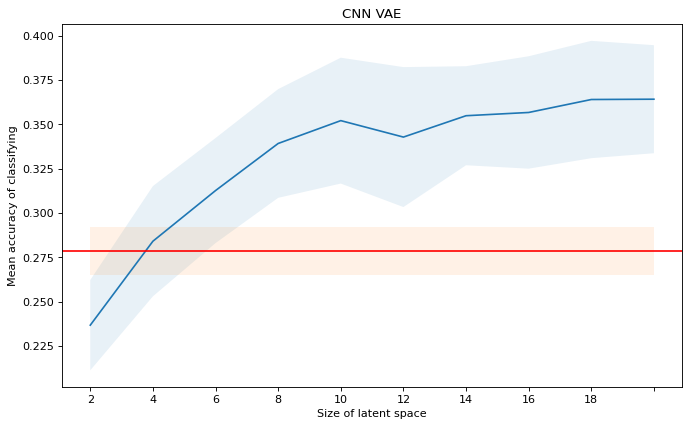

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

scorer = np.loadtxt("/content/drive/MyDrive/ColabNotebooks/projekt03/VAE_models/cnn_scores")
scorer = np.reshape(scorer, (10, 10, 10))
print(scorer.shape)

means = np.array([np.mean(i) for i in scorer])
stds = np.array([np.std(i) for i in scorer])

baseline_acc = [0.2784019975031211, 0.2958801498127341, 0.2815230961298377, 0.26279650436953805, 0.2690387016229713, 0.2746566791510612, 0.2565543071161049, 0.301498127340824, 0.2902621722846442, 0.2759051186017478]
baseline_mean = np.mean(baseline_acc)
baseline_std = np.std(baseline_acc)

plt.figure(figsize=(10, 6), dpi=80)

plt.plot (means)
plt.fill_between(range(10),means-stds,means+stds,alpha=.1)
plt.title("CNN VAE")
plt.xticks(range(10),[f"{i}" for i in range(2,20,2)])
plt.xlabel("Size of latent space")
plt.ylabel("Mean accuracy of classifying")
plt.axhline(y = baseline_mean, color = 'r', linestyle = '-')
plt.fill_between(range(10),baseline_mean-baseline_std,baseline_mean+baseline_std,alpha=.1)
plt.show()